In [1]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Reading the highly correlated data
data=pd.read_csv('C:/Users/mugesh/Projects/Pubg/cleaned_data1.0.csv')
df=reduce_mem_usage(data)

Memory usage of dataframe is 696.69 MB --> 273.70 MB (Decreased by 60.7%)


In [4]:
# Turn groupId and match Id into categorical types
df['groupId'] = df['groupId'].astype('category')
df['matchId'] = df['matchId'].astype('category')
df['matchType'] = df['matchType'].astype('category')
# Get category coding for groupId and matchID
df['groupId_cat'] = df['groupId'].cat.codes
df['matchId_cat'] = df['matchId'].cat.codes
df['matchType_cat'] = df['matchType'].cat.codes
# Get rid of old columns
df.drop(columns=['groupId', 'matchId','matchType'], inplace=True)

In [5]:
X=df.drop('winPlacePerc',axis=1).values
y=df['winPlacePerc'].values

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X= scaler.fit_transform(X)

In [7]:
from sklearn.model_selection import train_test_split
X_train,test_val_X,y_train,test_val_y=train_test_split(X,y,test_size=0.2,random_state=101)
X_val,X_test,y_val,y_test=train_test_split(test_val_X,test_val_y,test_size=0.5,random_state=101)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
adam=Adam(learning_rate=0.0001)

In [11]:
model = Sequential()

model.add(Dense(32,activation='relu',kernel_initializer='he_uniform',input_dim = X_train.shape[1]))

model.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))

model.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))

model.add(Dense(32,activation='relu',kernel_initializer='he_uniform'))

model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='Adam',loss='mse')

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                672       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 9,057
Trainable params: 9,057
Non-trainable params: 0
_________________________________________________________________


In [13]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [14]:
model.fit(x=X_train,y=y_train,batch_size=100,epochs=50,validation_data=(X_val,y_val),callbacks=[early_stop])

Train on 3478716 samples, validate on 434839 samples
Epoch 1/50
3478716/3478716 [==============================] - 32s 9us/sample - loss: 0.0196 - val_loss: 0.0187
Epoch 2/50
3478716/3478716 [==============================] - 33s 10us/sample - loss: 0.0186 - val_loss: 0.0185
Epoch 3/50
3478716/3478716 [==============================] - 34s 10us/sample - loss: 0.0185 - val_loss: 0.0185
Epoch 4/50
3478716/3478716 [==============================] - 36s 10us/sample - loss: 0.0184 - val_loss: 0.0184
Epoch 5/50
3478716/3478716 [==============================] - 40s 11us/sample - loss: 0.0184 - val_loss: 0.0184
Epoch 6/50
3478716/3478716 [==============================] - 35s 10us/sample - loss: 0.0184 - val_loss: 0.0184
Epoch 7/50
3478716/3478716 [==============================] - 34s 10us/sample - loss: 0.0184 - val_loss: 0.0185


In [15]:
losses = pd.DataFrame(model.history.history)

In [16]:
losses

,loss,val_loss
0,0.019565,0.018653
1,0.018602,0.018489
2,0.018493,0.018469
3,0.018444,0.018447
4,0.018407,0.018384
5,0.018383,0.018409
6,0.018367,0.018494


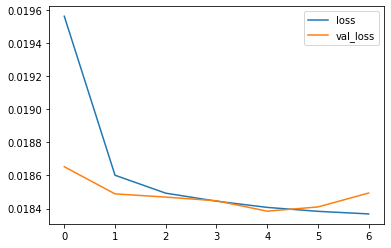

In [17]:
losses.plot()

In [18]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [19]:
pred_y=model.predict(X_test)

In [20]:
mean_squared_error(pred_y,y_test)

0.018439813

In [21]:
r2_score(pred_y,y_test)

0.7613148331169163

In [22]:
from tensorflow.keras.models import load_model
model.save('pubg_nn_model.h5')

###### PREDICTING A SINGLE PLAYER'S PLACEMENT

In [49]:
player = df.drop('winPlacePerc',axis=1).iloc[544558]

In [50]:
player=player.values.reshape(1, -1)

In [51]:
player = scaler.transform(player)

In [52]:
df.winPlacePerc.iloc[544558]

0.2128

In [53]:
model.predict(player)

array([[0.2777987]], dtype=float32)